# Learning to Play MsPacman Using the DQN Algorithm

In [1]:
import tensorflow as tf

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)    

In [2]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

## Creating the MsPacman environment

In [4]:
import gym

env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

(210, 160, 3)

In [5]:
env.action_space

Discrete(9)

## Preprocessing

Preprocessing the images is optional but greatly speeds up training.

In [6]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

Note: the `preprocess_observation()` function is slightly different from the one in the book: instead of representing pixels as 64-bit floats from -1.0 to 1.0, it represents them as signed bytes (from -128 to 127). The benefit is that the replay memory will take up roughly 8 times less RAM (about 6.5 GB instead of 52 GB). The reduced precision has no visible impact on training.

<IPython.core.display.Javascript object>


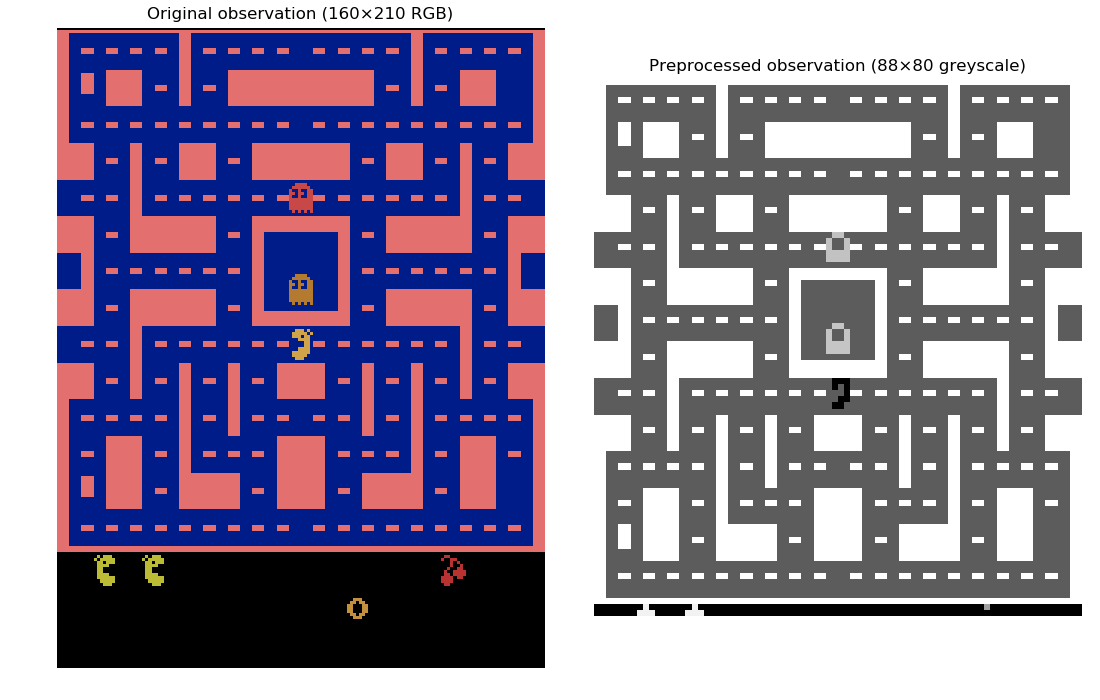

Saving figure preprocessing_plot


In [7]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
save_fig("preprocessing_plot")
plt.show()

## Build DQN

Note: instead of using `tf.contrib.layers.convolution2d()` or `tf.contrib.layers.conv2d()` (as in the first version of the book), we now use the `tf.layers.conv2d()`, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same, except that the parameter names have changed slightly:
* the `num_outputs` parameter was renamed to `filters`,
* the `stride` parameter was renamed to `strides`,
* the `_fn` suffix was removed from parameter names that had it (e.g., `activation_fn` was renamed to `activation`),
* the `weights_initializer` parameter was renamed to `kernel_initializer`,
* the weights variable was renamed to `"kernel"` (instead of `"weights"`), and the biases variable was renamed from `"biases"` to `"bias"`,
* and the default `activation` is now `None` instead of `tf.nn.relu`.

In [8]:
reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.contrib.layers.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [10]:
online_vars

{'/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/dense_1/kernel:0' shape=(512, 9) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/onl

In [11]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Note: in the first version of the book, the loss function was simply the squared error between the target Q-Values (`y`) and the estimated Q-Values (`q_value`). However, because the experiences are very noisy, it is better to use a quadratic loss only for small errors (below 1.0) and a linear loss (twice the absolute error) for larger errors, which is what the code above computes. This way large errors don't push the model parameters around as much. Note that we also tweaked some hyperparameters (using a smaller learning rate, and using Nesterov Accelerated Gradients rather than Adam optimization, since adaptive gradient algorithms may sometimes be bad, according to this [paper](https://arxiv.org/abs/1705.08292)). We also tweaked a few other hyperparameters below (a larger replay memory, longer decay for the $\epsilon$-greedy policy, larger discount rate, less frequent copies of the online DQN to the target DQN, etc.).

We use this `ReplayMemory` class instead of a `deque` because it is much faster for random access (thanks to @NileshPS who contributed it). Moreover, we default to sampling with replacement, which is much faster than sampling without replacement for large replay memories.

In [12]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [13]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

In [14]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [15]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [16]:
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

A few variables for tracking progress:

In [17]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

And now the main training loop!

You can interrupt the cell above at any time to test your agent using the cell below. You can then run the cell above once again, it will load the last parameters saved and resume training.

In [18]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


<IPython.core.display.Javascript object>


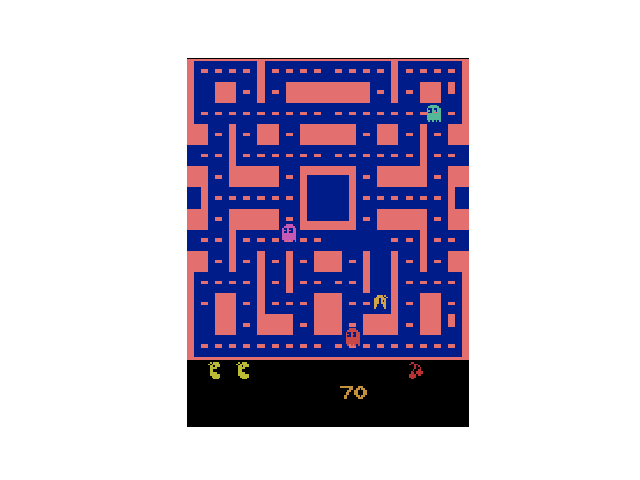

In [19]:
plot_animation(frames)